# Attention Networks Demo

## Hand-written digit classification with attention networks

In this demo, we will show how to build a convolutional neural networks for hand-written digit classification. We will use MNIST as the dataset.

In [1]:
import torch
import torchvision

Set random seed

In [2]:
random_seed = 9999
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

Load the dataset using Pytorch API. First we load the training set. The training set contains 60000 images and the test set contains 10000 images. 

In [3]:
batch_size_train = 64
batch_size_test = 1000


trainset = torchvision.datasets.MNIST('./', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

print (len(trainset))

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size_train, shuffle=True)

60000


In [4]:
testset = torchvision.datasets.MNIST('./', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

print (len(testset))

test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size_test, shuffle=True)

10000


Let's show some example images.

In [5]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

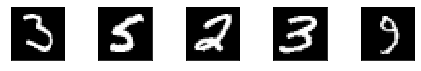

In [6]:
import matplotlib.pyplot as plt

fig = plt.figure()

for i in range(5):
  plt.subplot(1,5,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.xticks([])
  plt.yticks([])

In [7]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

Let's build a convolutional neural network (CNN) with attention mechanism. 

In [8]:

class AttentionNet(nn.Module):
    def __init__(self):
        super(AttentionNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, padding=1, kernel_size=3)
        self.attention1 = nn.Conv2d(1, 1, padding=1, kernel_size=3)
        self.conv2 = nn.Conv2d(10, 20, padding=1, kernel_size=3)
        self.attention2 = nn.Conv2d(10, 1, padding=1, kernel_size=3)
        
        self.conv3 = nn.Conv2d(20, 40, padding=1, kernel_size=3)
        self.attention3 = nn.Conv2d(20, 1, padding=1, kernel_size=3)
        self.conv4 = nn.Conv2d(40, 80, padding=1, kernel_size=3)
        self.attention4 = nn.Conv2d(40, 1, padding=1, kernel_size=3)
        
        self.fc1 = nn.Linear(80, 50)
        self.fc2 = nn.Linear(50, 10)
        
    def forward(self, x):
        
        attention = F.sigmoid(self.attention1(x))
        x = self.conv1(x)
        x = x * attention
        x = F.relu(F.max_pool2d(x, 2))
        
        attention = F.sigmoid(self.attention2(x))
        x = self.conv2(x)
        x = x * attention
        x = F.relu(F.max_pool2d(x, 2))
        
        attention = F.sigmoid(self.attention3(x))
        x = self.conv3(x)
        x = x * attention
        x = F.relu(F.max_pool2d(x, 2))
        
        attention = F.sigmoid(self.attention4(x))
        x = self.conv4(x)
        x = x * attention
        x = F.relu(F.max_pool2d(x, 2))
      

        x_ft = x.view(-1, x.size(1) * x.size(2) * x.size(3))
        
        
        x_ft = F.relu(self.fc1(x_ft))
        
        logits = self.fc2(x_ft)
        
        return F.log_softmax(logits)

In [9]:
network = AttentionNet()

print (network)

AttentionNet(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (attention1): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (attention2): Conv2d(10, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(20, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (attention3): Conv2d(20, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(40, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (attention4): Conv2d(40, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=80, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


For training the network, we need to specify the optimizer. 

In [10]:
n_epochs = 10
learning_rate = 0.01
momentum = 0.9
log_interval = 10

optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)


In [11]:
train_losses = []
test_losses = []

In [12]:
def train(epoch):
  network.train()
   
  train_loss = 0

  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    
    output = network(data)
    loss = F.nll_loss(output, target)
    
    train_loss += loss.item()
    
    loss.backward()
    
    optimizer.step()
    
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
    
  
  train_loss /= len(train_loader.dataset)
  train_losses.append(train_loss)
        

In [13]:
def test():
  network.eval()

  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)

  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [14]:
for epoch in range(1, n_epochs + 1):
  
  train(epoch)
  test()

/Users/yunhui.guo/.local/lib/python3.6/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/Users/yunhui.guo/.local/lib/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.307003
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.303166
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.314470
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.295414
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.299490
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.302544
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.304816
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.310052
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.307564
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.310531
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.295472
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.302694
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.298516
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.308739
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.297976
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.298272
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.301678
Train Epoch: 1 [10880/60000 (18%)]	Loss: 2.305990
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.289377
Train Epoch: 1 [12160/60000 (20%)]	Loss: 2.303491
Train Epoch: 1 [12800/60000 (

/Users/yunhui.guo/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.1364, Accuracy: 9577/10000 (96%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.078946
Train Epoch: 2 [640/60000 (1%)]	Loss: 0.056543
Train Epoch: 2 [1280/60000 (2%)]	Loss: 0.193235
Train Epoch: 2 [1920/60000 (3%)]	Loss: 0.091801
Train Epoch: 2 [2560/60000 (4%)]	Loss: 0.349144
Train Epoch: 2 [3200/60000 (5%)]	Loss: 0.167716
Train Epoch: 2 [3840/60000 (6%)]	Loss: 0.209072
Train Epoch: 2 [4480/60000 (7%)]	Loss: 0.089207
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.232926
Train Epoch: 2 [5760/60000 (10%)]	Loss: 0.173032
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.169245
Train Epoch: 2 [7040/60000 (12%)]	Loss: 0.049301
Train Epoch: 2 [7680/60000 (13%)]	Loss: 0.070981
Train Epoch: 2 [8320/60000 (14%)]	Loss: 0.136534
Train Epoch: 2 [8960/60000 (15%)]	Loss: 0.092960
Train Epoch: 2 [9600/60000 (16%)]	Loss: 0.046221
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.089420
Train Epoch: 2 [10880/60000 (18%)]	Loss: 0.247924
Train Epoch: 2 [11520/60000 (19%)]	Loss: 0.120276
Train Epoch: 2 [12160

Train Epoch: 3 [44160/60000 (74%)]	Loss: 0.040483
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.047835
Train Epoch: 3 [45440/60000 (76%)]	Loss: 0.019464
Train Epoch: 3 [46080/60000 (77%)]	Loss: 0.058639
Train Epoch: 3 [46720/60000 (78%)]	Loss: 0.043236
Train Epoch: 3 [47360/60000 (79%)]	Loss: 0.079186
Train Epoch: 3 [48000/60000 (80%)]	Loss: 0.021618
Train Epoch: 3 [48640/60000 (81%)]	Loss: 0.042534
Train Epoch: 3 [49280/60000 (82%)]	Loss: 0.007081
Train Epoch: 3 [49920/60000 (83%)]	Loss: 0.061085
Train Epoch: 3 [50560/60000 (84%)]	Loss: 0.078572
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.114743
Train Epoch: 3 [51840/60000 (86%)]	Loss: 0.096931
Train Epoch: 3 [52480/60000 (87%)]	Loss: 0.033428
Train Epoch: 3 [53120/60000 (88%)]	Loss: 0.076544
Train Epoch: 3 [53760/60000 (90%)]	Loss: 0.073259
Train Epoch: 3 [54400/60000 (91%)]	Loss: 0.046346
Train Epoch: 3 [55040/60000 (92%)]	Loss: 0.024972
Train Epoch: 3 [55680/60000 (93%)]	Loss: 0.022198
Train Epoch: 3 [56320/60000 (94%)]	Loss: 0.123923


Train Epoch: 5 [28160/60000 (47%)]	Loss: 0.118735
Train Epoch: 5 [28800/60000 (48%)]	Loss: 0.069006
Train Epoch: 5 [29440/60000 (49%)]	Loss: 0.009543
Train Epoch: 5 [30080/60000 (50%)]	Loss: 0.039947
Train Epoch: 5 [30720/60000 (51%)]	Loss: 0.019479
Train Epoch: 5 [31360/60000 (52%)]	Loss: 0.153849
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.045214
Train Epoch: 5 [32640/60000 (54%)]	Loss: 0.025490
Train Epoch: 5 [33280/60000 (55%)]	Loss: 0.033629
Train Epoch: 5 [33920/60000 (57%)]	Loss: 0.015742
Train Epoch: 5 [34560/60000 (58%)]	Loss: 0.043036
Train Epoch: 5 [35200/60000 (59%)]	Loss: 0.034043
Train Epoch: 5 [35840/60000 (60%)]	Loss: 0.030966
Train Epoch: 5 [36480/60000 (61%)]	Loss: 0.002069
Train Epoch: 5 [37120/60000 (62%)]	Loss: 0.185441
Train Epoch: 5 [37760/60000 (63%)]	Loss: 0.028906
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.001360
Train Epoch: 5 [39040/60000 (65%)]	Loss: 0.013534
Train Epoch: 5 [39680/60000 (66%)]	Loss: 0.009507
Train Epoch: 5 [40320/60000 (67%)]	Loss: 0.067391


Train Epoch: 7 [12160/60000 (20%)]	Loss: 0.070689
Train Epoch: 7 [12800/60000 (21%)]	Loss: 0.007173
Train Epoch: 7 [13440/60000 (22%)]	Loss: 0.006463
Train Epoch: 7 [14080/60000 (23%)]	Loss: 0.001186
Train Epoch: 7 [14720/60000 (25%)]	Loss: 0.004810
Train Epoch: 7 [15360/60000 (26%)]	Loss: 0.009431
Train Epoch: 7 [16000/60000 (27%)]	Loss: 0.043009
Train Epoch: 7 [16640/60000 (28%)]	Loss: 0.015097
Train Epoch: 7 [17280/60000 (29%)]	Loss: 0.006939
Train Epoch: 7 [17920/60000 (30%)]	Loss: 0.007240
Train Epoch: 7 [18560/60000 (31%)]	Loss: 0.043933
Train Epoch: 7 [19200/60000 (32%)]	Loss: 0.043092
Train Epoch: 7 [19840/60000 (33%)]	Loss: 0.012888
Train Epoch: 7 [20480/60000 (34%)]	Loss: 0.022453
Train Epoch: 7 [21120/60000 (35%)]	Loss: 0.095615
Train Epoch: 7 [21760/60000 (36%)]	Loss: 0.040605
Train Epoch: 7 [22400/60000 (37%)]	Loss: 0.008959
Train Epoch: 7 [23040/60000 (38%)]	Loss: 0.035197
Train Epoch: 7 [23680/60000 (39%)]	Loss: 0.025741
Train Epoch: 7 [24320/60000 (41%)]	Loss: 0.003391


Train Epoch: 8 [56960/60000 (95%)]	Loss: 0.015157
Train Epoch: 8 [57600/60000 (96%)]	Loss: 0.036630
Train Epoch: 8 [58240/60000 (97%)]	Loss: 0.001377
Train Epoch: 8 [58880/60000 (98%)]	Loss: 0.001245
Train Epoch: 8 [59520/60000 (99%)]	Loss: 0.000321

Test set: Avg. loss: 0.0310, Accuracy: 9908/10000 (99%)

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.013247
Train Epoch: 9 [640/60000 (1%)]	Loss: 0.000807
Train Epoch: 9 [1280/60000 (2%)]	Loss: 0.002100
Train Epoch: 9 [1920/60000 (3%)]	Loss: 0.006460
Train Epoch: 9 [2560/60000 (4%)]	Loss: 0.016230
Train Epoch: 9 [3200/60000 (5%)]	Loss: 0.003121
Train Epoch: 9 [3840/60000 (6%)]	Loss: 0.041203
Train Epoch: 9 [4480/60000 (7%)]	Loss: 0.003430
Train Epoch: 9 [5120/60000 (9%)]	Loss: 0.007468
Train Epoch: 9 [5760/60000 (10%)]	Loss: 0.015485
Train Epoch: 9 [6400/60000 (11%)]	Loss: 0.024107
Train Epoch: 9 [7040/60000 (12%)]	Loss: 0.001069
Train Epoch: 9 [7680/60000 (13%)]	Loss: 0.009967
Train Epoch: 9 [8320/60000 (14%)]	Loss: 0.015089
Train Epoch: 9 [896

Train Epoch: 10 [40320/60000 (67%)]	Loss: 0.000062
Train Epoch: 10 [40960/60000 (68%)]	Loss: 0.013111
Train Epoch: 10 [41600/60000 (69%)]	Loss: 0.000368
Train Epoch: 10 [42240/60000 (70%)]	Loss: 0.003764
Train Epoch: 10 [42880/60000 (71%)]	Loss: 0.020873
Train Epoch: 10 [43520/60000 (72%)]	Loss: 0.006176
Train Epoch: 10 [44160/60000 (74%)]	Loss: 0.000547
Train Epoch: 10 [44800/60000 (75%)]	Loss: 0.002414
Train Epoch: 10 [45440/60000 (76%)]	Loss: 0.008838
Train Epoch: 10 [46080/60000 (77%)]	Loss: 0.003223
Train Epoch: 10 [46720/60000 (78%)]	Loss: 0.011136
Train Epoch: 10 [47360/60000 (79%)]	Loss: 0.058269
Train Epoch: 10 [48000/60000 (80%)]	Loss: 0.027688
Train Epoch: 10 [48640/60000 (81%)]	Loss: 0.008120
Train Epoch: 10 [49280/60000 (82%)]	Loss: 0.003647
Train Epoch: 10 [49920/60000 (83%)]	Loss: 0.011353
Train Epoch: 10 [50560/60000 (84%)]	Loss: 0.007313
Train Epoch: 10 [51200/60000 (85%)]	Loss: 0.027752
Train Epoch: 10 [51840/60000 (86%)]	Loss: 0.000550
Train Epoch: 10 [52480/60000 (8

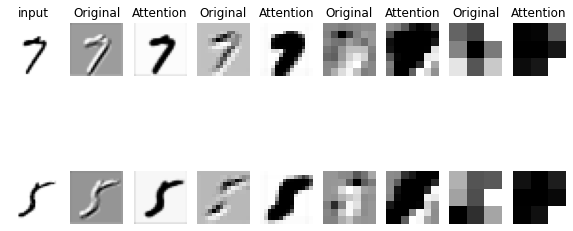

In [15]:
import matplotlib.pyplot as plt


def visualize_attention(att_net, test_loader):
    
    for (inputs, labels) in test_loader:
        
        plt.figure(figsize=[10, 5])
        
        for i in range(2):
            plt.subplot(2, 9, 1 + 9*i)
            if i == 0:
                plt.title('input')
        
            plt.axis('off')
            plt.imshow(inputs[i, 0].data.cpu().numpy(), cmap='Greys')
            
            oris, atts = get_attention(att_net, inputs[i:(i+1)])
            
            for j, (ori, att) in enumerate(zip(oris, atts)):
                
                plt.subplot(2, 9, 2*j + 9 * i + 2)
                if i == 0:
                    plt.title('Original')
                
                tmp = ori.data.cpu().numpy()
                plt.axis('off')
                plt.imshow(tmp[0, 0], cmap='Greys')
                
                plt.subplot(2, 9, 2*j + 9 * i + 3)
                
                if i == 0:
                    plt.title('Attention')
                    
                tmp = att.data.cpu().numpy()
                
                plt.axis('off')
                plt.imshow(tmp[0, 0], cmap='Greys')
       
        break
        
def get_attention(att_net, x):
        
    attention1 = F.sigmoid(att_net.attention1(x))
    x1_ori = att_net.conv1(x)
    x1 = x1_ori * attention1
    x = F.relu(F.max_pool2d(x1, 2))

    attention2 = F.sigmoid(att_net.attention2(x))
    x2_ori = att_net.conv2(x)
    x2 = x2_ori * attention2
    x = F.relu(F.max_pool2d(x2, 2))

    attention3 = F.sigmoid(att_net.attention3(x))
    x3_ori = att_net.conv3(x)
    x3 = x3_ori * attention3
    x = F.relu(F.max_pool2d(x3, 2))

    attention4 = F.sigmoid(att_net.attention4(x))
    x4_ori = att_net.conv4(x)
    x4 = x4_ori * attention4
    x = F.relu(F.max_pool2d(x4, 2))
    
    return [x1_ori, x2_ori, x3_ori, x4_ori], [attention1, attention2, attention3, attention4]


visualize_attention(network, test_loader)